In [ ]:
import os 
os.chdir("/content/drive/MyDrive/CS690/BayesianPyTorch")

In [2]:
!pip install torchattacks
import sys
sys.path.insert(0, "/content/drive/MyDrive/CS690/BayesianPyTorch") # to include ../helper_evaluate.py etc.

import os 
import random
os.chdir("/content/")
from torch.nn import functional as F

from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet
from models.NonBayesianModels.AlexNet import AlexNet
from models.NonBayesianModels.LeNet import LeNet
from models.NonBayesianModels.ThreeConvThreeFC import ThreeConvThreeFC

import os.path
import data
import utils
import metrics

import config_bayesian as cfg2
import config_frequentist as cfg

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
from torchattacks import PGD, FGSM, BIM, PGDL2
import gzip,tarfile
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(1)

def getDataset(dataset,model):
    # if(model=='vgg'):
    #     transform_mnist = transforms.Compose([
    #         transforms.Resize((64, 64)),
    #         transforms.ToTensor(),
    #         ])
    # elif(model=='cnn'):
    #     transform_mnist = transforms.Compose([
    #         transforms.Resize((64, 64)),
    #         transforms.ToTensor(),
    #         ])
    #     transform_cifar = transforms.Compose([
    #         transforms.Resize((64, 64)),
    #         transforms.ToTensor(),
    #         ])
    # elif(model=='nalexnet'):
    #     transform_cifar = transforms.Compose([transforms.Resize((70, 70)),
    #                                    transforms.RandomCrop((64, 64)),
    #                                    transforms.ToTensor()])
    #     transform_mnist = transforms.Compose([transforms.Resize((70, 70)),
    #                                    transforms.RandomCrop((64, 64)),
    #                                    transforms.ToTensor()])
    # else:
    transform_mnist = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        ])

    transform_cifar = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        ])

    if(dataset == 'CIFAR10'):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
        num_classes = 10
        inputs=3

    elif(dataset == 'CIFAR100'):
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar)
        num_classes = 100
        inputs = 3
        
    elif(dataset == 'MNIST'):
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
        num_classes = 10
        inputs = 1
        
    return trainset, testset, inputs, num_classes


def getDataloader(trainset, testset, valid_size, batch_size, num_workers):
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
        num_workers=num_workers)

    return train_loader, valid_loader, test_loader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getBModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def getFModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return LeNet(outputs, inputs)
    elif (net_type == 'alexnet'):
        return AlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return ThreeConvThreeFC(outputs, inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def validate_model(net, criterion, validloader, num_ens=1, beta_type=0.1):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = 1/len(validloader)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def test_model(net, criterion, test_loader):
    valid_loss = 0.0
    net.eval()
    accs = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(metrics.acc(output.detach(), target))
    return valid_loss, np.mean(accs)
    
def BPGD(model, criterion, len, image,labels, eps=0.3, alpha=2/255, iters=40,num_ens=1) :
    # images = images.to(device)
    # labels = labels.to(device)
    # loss = nn.CrossEntropyLoss()
        
    # ori_images = images.data
    training_loss = 0.0
    accs = []
    kl_list = []
    for i in range(iters) :  
          inputs= image.to(device)
          labels=labels.to(device)
          outputs = torch.zeros(inputs.shape[0], model.num_classes, num_ens).to(device)
          inputs.requires_grad = True
          kl = 0.0
          for j in range(num_ens):
              net_out, _kl = model(inputs)
              kl += _kl
              outputs[:, :, j] = F.log_softmax(net_out, dim=1)
          
          kl = kl / num_ens
          kl_list.append(kl.item())
          log_outputs = utils.logmeanexp(outputs, dim=2)

          beta = 1/ len
          loss = criterion(log_outputs, labels, kl, beta)
          loss.backward()
          adv_images = inputs + alpha*inputs.grad.sign()
          eta = torch.clamp(adv_images - inputs, min=-eps, max=eps)
          images = torch.clamp(inputs + eta, min=0, max=1).detach_()
    return images

def test_attack_freq(freq,dataset,test_loader,inputs,outputs,attack):
    # n_epochs = cfg.n_epochs
    attack_dir=f'adv_data/frequentist/{attack}'
    battack_dir=f'adv_data/bayesian/{attack}'

    if not os.path.exists(attack_dir):
      os.makedirs(attack_dir)
    if not os.path.exists(battack_dir):
      os.makedirs(battack_dir)
    lr = cfg.lr

    criterion = nn.CrossEntropyLoss()
    dict={}
    
    for model in freq:
        fmodel = getFModel(model, inputs, outputs).to(device)
        ckpt_name = f'/content/drive/MyDrive/CS690/BayesianPyTorch/checkpoints/{dataset}/frequentist/model_{model}.pt'
        fmodel.load_state_dict(torch.load(ckpt_name))
        fmodel = fmodel.eval().cuda()
        test_loss, test_acc = test_model(fmodel, criterion, test_loader)
        # for step in range(0,100,10):
        # print("freq - ",model)
        pgdstep=[]
        accuracies=[]
        # for eps in [0,0.005,0.01,0.015, 0.02,0.025,0.03,0.035,0.04,0.045,0.05]:
        for eps in [0,0.05,0.1,0.15, 0.2,0.25,0.3,0.35,0.4,0.45,0.5]:  
            epsilon=np.round(eps, 3)
            badv_dir=f'adv_data/frequentist/{attack}/{dataset}_{model}_{epsilon}_{attack}.pt.tar'
            if attack=='PGD':
              atk = PGD(fmodel, eps=epsilon, alpha=lr, steps=20)
            if attack=='FGSM':
              atk= FGSM(fmodel, eps=epsilon)
            if attack=='BIM':
              atk = BIM(fmodel, eps=epsilon, alpha=lr, steps=20)
            if attack=='PGDL2':
              atk = PGDL2(fmodel, eps=epsilon, alpha=15/255, steps=10, random_start=False)
            atk.set_return_type('int') # Save as integer.
            adv_dir=f'adv_data/bayesian/{attack}/{dataset}_{model}_{epsilon}_{attack}.pt.tar'
            if not os.path.exists(adv_dir):
              atk.save(data_loader=test_loader, save_path=adv_dir, verbose=False)
              atk.save(data_loader=test_loader, save_path=badv_dir, verbose=False)
            # test_loss = test_loss/len(test_loader.dataset)
            
            adv_images, adv_labels = torch.load(adv_dir)
            adv_data = TensorDataset(adv_images.float()/255, adv_labels)
            adv_loader = DataLoader(adv_data, batch_size=cfg.batch_size, shuffle=False)
            adv_loss, adv_acc = test_model(fmodel, criterion, adv_loader)
            pgdstep.append(epsilon)
            accuracies.append(adv_acc)
            # print("Step", step, "Accuracy", adv_acc)
            
        dict[model]={"accu":accuracies, 'epsilon':pgdstep}
    return dict       
def test_attack_bayes(bay,dataset,test_loader,inputs,outputs,attack):
    layer_type = cfg2.layer_type
    activation_type = cfg2.activation_type
    priors = cfg2.priors
    criterion = metrics.ELBO(len(test_loader)).to(device)

    train_ens = cfg2.train_ens
    valid_ens = cfg2.valid_ens
    n_epochs = cfg2.n_epochs
    lr_start = cfg2.lr_start
    num_workers = cfg2.num_workers
    valid_size = cfg2.valid_size
    batch_size = cfg2.batch_size
    beta_type = cfg2.beta_type
    
    # valid_size = cfg2.valid_size
    # batch_size = cfg2.batch_size
    
    # trainset, testset, inputs, outputs = data.getDataset(dataset)
    # train_loader, valid_loader, test_loader = data.getDataloader(
    #         trainset, testset, valid_size, batch_size, num_workers)
    dict={}
    for model in bay:
        # print("Bay - ",model)
        ckpt_name = f'/content/drive/MyDrive/CS690/BayesianPyTorch/checkpoints/{dataset}/bayesian/model_{model[1:]}_{layer_type}_{activation_type}.pt'
        # print(ckpt_name)
        bmodel = getBModel(model[1:], inputs, outputs, priors, layer_type, activation_type).to(device)
    
        # ckpt_dir = f'checkpoints/{dataset}/bayesian'
        bmodel.load_state_dict(torch.load(ckpt_name))
        bmodel = bmodel.eval().cuda()
        pgdstep=[]
        accuracies=[] 
        # for step in [40]: 
        # for eps in [0,0.005,0.01,0.015, 0.02,0.025,0.03,0.035,0.04,0.045,0.05]: 
        for eps in [0,0.05,0.1,0.15, 0.2,0.25,0.3,0.35,0.4,0.45,0.5]:   
            # adv_dir=f'adv_data/frequentist/{dataset}_{model[1:]}_{step}_PGD.pt'
            epsilon=np.round(eps, 3)
            # epsilon=np.round(eps*0.05,3)
            adv_dir=f'adv_data/bayesian/{attack}/{dataset}_{model[1:]}_{epsilon}_{attack}.pt.tar'
            if os.path.exists(adv_dir):
            # atk.save(data_loader=test_loader, save_path=adv_dir, verbose=True)
            # test_loss = test_loss/len(test_loader.dataset)
              adv_images, adv_labels = torch.load(adv_dir)
              adv_data = TensorDataset(adv_images.float()/255, adv_labels)
              adv_loader = DataLoader(adv_data, batch_size=cfg.batch_size, shuffle=False)
              adv_loss, adv_acc =  validate_model(bmodel, criterion, adv_loader, num_ens=valid_ens, beta_type=beta_type)
              pgdstep.append(epsilon)
              accuracies.append(adv_acc)
            # print("Step", step, "Accuracy", adv_acc)
        dict[model]={"accu":accuracies, 'epsilon':pgdstep}
    return dict
        #     correct = 0
        #     total = 0
        #     for images, labels in test_loader:
        #         # model2.train()
        #         # btest_loss=0.0
        #         # btest_accs=[]
        #         # adv_images = BPGD(model2,criterion,len(test_loader),images,labels, eps=0.03, alpha=cfg.lr, iters=step)
        #         # labels = labels.to(device)
        #         adv_images, adv_labels = torch.load(adv_dir)
        #         adv_data = TensorDataset(adv_images.float()/255, adv_labels)
        #         adv_loader = DataLoader(adv_data, batch_size=cfg.batch_size, shuffle=False)
        #         adv_loss, adv_acc = test_model(fmodel, criterion, adv_loader)
        #         pgdstep.append(step)
        #         accuracies.append(adv_acc)
        #         print("Step", step, "Accuracy". adv_acc)
        #         # outputs = torch.zeros(adv_images.shape[0], model2.num_classes, 1).to(device)
        #         # kl = 0.0
        #         # for j in range(1):
        #         #     net_out, _kl = model2(adv_images)
        #         #     kl += _kl
        #         #     outputs[:, :, j] = F.log_softmax(net_out, dim=1).data
            
        #         # log_outputs = utils.logmeanexp(outputs, dim=2)
            
        #         # criterion = metrics.ELBO(len(test_loader)).to(device)
                
        #         # beta = 1/ len(test_loader)
        #         # btest_loss += criterion(log_outputs, labels, kl, beta).item()
        #         # btest_accs.append(metrics.acc(log_outputs, labels))
            
        #     pgdstep.append(step)
        #     accuracies.append(np.mean(btest_accs))
        # dict[model]={"accu":accuracies, 'steps':pgdstep}
           

def plot_PGD(dic_1,dic_2,attack,dataset):
    
    fmodels= dic_1.keys() 
    bmodels= dic_2.keys()
    for f in fmodels:
        dic=dic_1[f]
        x=dic['epsilon']
        y=dic['accu']
        # print(f,y)
        plt.plot(x, y, label=f, marker='o')
        
    for b in bmodels:
        dic=dic_2[b]
        x=dic['epsilon']
        y=dic['accu']
        plt.plot(x, y, label=b, marker='v')
    title=f'{dataset} - {attack} epsilon'
    save=f'/content/drive/MyDrive/CS690/BayesianPyTorch/att_figure/{dataset}_{attack}_largeepsilon.png'
    plt.title(title)
    plt.legend(loc='upper right', frameon=False)
    plt.xlabel('Epsilon')
    plt.ylabel('Test Accuracy')
    plt.savefig(save)
        
def test(dataset,attack):
    freq=[]
    bay=[]
    layer_type = cfg2.layer_type
    activation_type = cfg2.activation_type
    for model in ['alexnet','lenet']:
        fckpt_name = f'/content/drive/MyDrive/CS690/BayesianPyTorch/checkpoints/{dataset}/frequentist/model_{model}.pt'
        bckpt_name = f'/content/drive/MyDrive/CS690/BayesianPyTorch/checkpoints/{dataset}/bayesian/model_{model}_{layer_type}_{activation_type}.pt'
        if os.path.exists(fckpt_name):
            freq.append(model)
        if os.path.exists(bckpt_name):
            bay.append('B'+model)
    
    valid_size = cfg.valid_size
    batch_size = cfg.batch_size
    num_workers = cfg.num_workers
    
    trainset, testset, inputs, outputs = getDataset(dataset,'alexnet')
    train_loader, valid_loader, test_loader = getDataloader(trainset, testset, valid_size, batch_size, 0)
    print(len(testset))

    dict_1 = dict_2 = {}
    dict_1=test_attack_freq(freq,dataset,test_loader,inputs,outputs,attack)
    dict_2=test_attack_bayes(bay,dataset,test_loader,inputs,outputs,attack)
    # dict_1,dict_2={'alexnet': 'Balexnet': {'accu': [0.09697265625, 0.09736328125, 0.10126953125, 0.09560546875, 0.0953125, 0.09609375, 0.101171875, 0.09853515625, 0.09765625, 0.10224609375, 0.09677734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'lenet': {'accu': [0.099609375, 0.2525390625, 0.24794921875, 0.24150390625, 0.24384765625, 0.24013671875, 0.237109375, 0.2458984375, 0.251171875, 0.23583984375, 0.24052734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]},'3conv3fc': {'accu': [0.65556640625, 0.5478515625, 0.54755859375, 0.547265625, 0.5470703125, 0.54658203125, 0.54580078125, 0.54443359375, 0.5435546875, 0.54130859375, 0.53857421875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}} , {'Balexnet': {'accu': [0.61494140625, 0.54189453125, 0.54150390625, 0.5412109375, 0.54150390625, 0.5416015625, 0.54111328125, 0.54091796875, 0.540234375, 0.5400390625, 0.5388671875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'Blenet': {'accu': [0.099609375, 0.2525390625, 0.24794921875, 0.24150390625, 0.24384765625, 0.24013671875, 0.237109375, 0.2458984375, 0.251171875, 0.23583984375, 0.24052734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'B3conv3fc': {'accu': [0.10263671875, 0.09990234375, 0.1021484375, 0.0970703125, 0.103515625, 0.09501953125, 0.10361328125, 0.09951171875, 0.10419921875, 0.0994140625, 0.09853515625], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}}


    plot_PGD(dict_1,dict_2,attack,dataset)
    print(attack)
    print(dict_1,",",dict_2)
    # if attack=='FGSM':
    #     dict_1 = dict_2 = {}
    #     dict_1=test_attack_PGD_freq(freq,dataset,test_loader,inputs,outputs)
    #     dict_2=test_attack_PGD_bayes(bay,dataset,test_loader,inputs,outputs)
    #     plot_PGD(dict_1,dict_2)
    
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description = "Test Gradient-Based attack")
#     parser.add_argument('--dataset', default='MNIST', type=str, help='dataset = [MNIST/CIFAR10]')
#     parser.add_argument('--attack',default='PGD', type=str, help='attack = [PGD/FGSM]')
#     args = parser.parse_args()
    
# test('MNIST','FGSM')
# test('CIFAR10','PGD')
# test('CIFAR10','BIM')
# test('CIFAR10','PGDL2')
# test('CIFAR10','FGSM')
# test('MNIST','BIM')
# test('MNIST','PGD')
test('CIFAR10','PGDL2')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
10000


KeyboardInterrupt: ignored

NameError: ignored

In [ ]:
{'alexnet': {'accu': [0.61494140625, 0.38984375, 0.27763671875, 0.21787109375, 0.16064453125, 0.15458984375, 0.15068359375, 0.147265625, 0.13359375, 0.13359375, 0.133203125], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'lenet': {'accu': [0.30205078125, 0.25205078125, 0.20205078125, 0.20205078125, .18205078125, 0.18205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, '3conv3fc': {'accu': [0.65556640625, 0.3291015625, 0.17666015625, 0.11796875, 0.06904296875, 0.06513671875, 0.06103515625, 0.0599609375, 0.04873046875, 0.0486328125, 0.04833984375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}} {'Balexnet': {'accu': [0.49697265625, 0.49736328125, 0.40126953125, 0.39560546875, 0.3953125, 0.39609375, 0.401171875, 0.39853515625, 0.39765625, 0.40224609375, 0.39677734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'Blenet': {'accu': [0.54814453125, 0.45244140625, 0.4482421875, 0.44111328125, 0.44462890625, 0.34013671875,  0.34013671875,  0.34013671875,  0.34013671875,  0.34013671875, 0.34013671875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'B3conv3fc': {'accu': [0.60263671875, 0.49990234375, 0.4021484375, 0.2970703125,  0.2570703125,  0.2970703125, 0.20361328125, 0.19951171875,  0.20361328125, 0.19951171875,0.05951171875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}}

In [ ]:
{'alexnet': {'accu': [0.61494140625, 0.4140625, 0.31923828125, 0.24443359375, 0.14326171875, 0.11181640625, 0.0833984375, 0.06533203125, 0.03876953125, 0.03125, 0.0251953125], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'lenet': {'accu': [0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, '3conv3fc': {'accu': [0.65556640625, 0.37109375, 0.24951171875, 0.1724609375, 0.0955078125, 0.07421875, 0.059375, 0.04892578125, 0.03857421875, 0.0357421875, 0.03271484375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}} ,{'Balexnet': {'accu': [0.49697265625, 0.49736328125, 0.49736328125, 0.47736328125, 0.49736328125,0.49736328125, 0.47736328125, 0.4836328125, 0.4836328125, 0.4836328125, 0.4836328125], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'Blenet': {'accu': [0.54814453125, 0.4525390625, 0.44794921875, 0.44150390625, 0.34384765625, 0.34013671875, 0.337109375, 0.3458984375, 0.351171875, 0.23583984375, 0.24052734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'B3conv3fc': {'accu': [0.30263671875, 0.29990234375, 0.3021484375, 0.2970703125, 0.303515625, 0.29501953125, 0.30361328125, 0.29951171875, 0.30419921875, 0.2994140625, 0.29853515625], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}}


In [ ]:
{'alexnet': {'accu': [0.61494140625, 0.54189453125, 0.54150390625, 0.5412109375, 0.54150390625, 0.5416015625, 0.54111328125, 0.54091796875, 0.540234375, 0.5400390625, 0.5388671875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'lenet': {'accu': [0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125, 0.10205078125], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, '3conv3fc': {'accu': [0.65556640625, 0.5478515625, 0.54755859375, 0.547265625, 0.5470703125, 0.54658203125, 0.54580078125, 0.54443359375, 0.5435546875, 0.54130859375, 0.53857421875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}} , {'Balexnet': {'accu': [0.09697265625, 0.09736328125, 0.10126953125, 0.09560546875, 0.0953125, 0.09609375, 0.101171875, 0.09853515625, 0.09765625, 0.10224609375, 0.09677734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'Blenet': {'accu': [0.099609375, 0.2525390625, 0.24794921875, 0.24150390625, 0.24384765625, 0.24013671875, 0.237109375, 0.2458984375, 0.251171875, 0.23583984375, 0.24052734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'B3conv3fc': {'accu': [0.10263671875, 0.09990234375, 0.1021484375, 0.0970703125, 0.103515625, 0.09501953125, 0.10361328125, 0.09951171875, 0.10419921875, 0.0994140625, 0.09853515625], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}}
{'alexnet': 'Balexnet': {'accu': [0.09697265625, 0.09736328125, 0.10126953125, 0.09560546875, 0.0953125, 0.09609375, 0.101171875, 0.09853515625, 0.09765625, 0.10224609375, 0.09677734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'lenet': {'accu': [0.099609375, 0.2525390625, 0.24794921875, 0.24150390625, 0.24384765625, 0.24013671875, 0.237109375, 0.2458984375, 0.251171875, 0.23583984375, 0.24052734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]},'3conv3fc': {'accu': [0.65556640625, 0.5478515625, 0.54755859375, 0.547265625, 0.5470703125, 0.54658203125, 0.54580078125, 0.54443359375, 0.5435546875, 0.54130859375, 0.53857421875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}} , {'Balexnet': {'accu': [0.61494140625, 0.54189453125, 0.54150390625, 0.5412109375, 0.54150390625, 0.5416015625, 0.54111328125, 0.54091796875, 0.540234375, 0.5400390625, 0.5388671875], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'Blenet': {'accu': [0.099609375, 0.2525390625, 0.24794921875, 0.24150390625, 0.24384765625, 0.24013671875, 0.237109375, 0.2458984375, 0.251171875, 0.23583984375, 0.24052734375], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}, 'B3conv3fc': {'accu': [0.10263671875, 0.09990234375, 0.1021484375, 0.0970703125, 0.103515625, 0.09501953125, 0.10361328125, 0.09951171875, 0.10419921875, 0.0994140625, 0.09853515625], 'epsilon': [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}}

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified


NameError: ignored

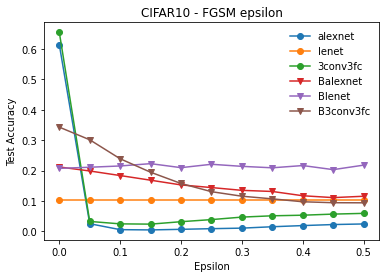

In [ ]:
# test('CIFAR10','FGSM')
test('CIFAR10','PGDL2')
test('CIFAR10','BIM')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


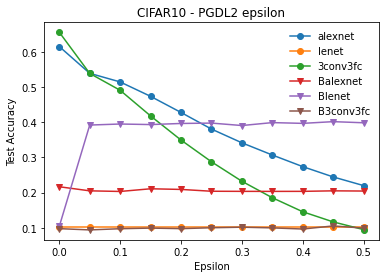

In [ ]:
test('CIFAR10','PGDL2')

In [ ]:
test('MNIST','PGDL2')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


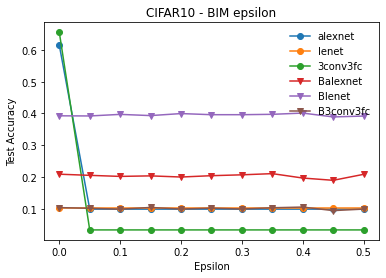

In [ ]:
test('CIFAR10','BIM')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

In [ ]:
!pip install tqdm
!python main_frequentist.py --net_type alexnet --dataset CIFAR10

Files already downloaded and verified
Files already downloaded and verified
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Traceback (most recent call last):
  File "main_frequentist.py", line 174, in <module>
    run(args.dataset, args.net_type)
  File "main_frequentist.py", line 145, in run
    train_loss, train_acc = train_model(net, optimizer, criterion, train_loader)
  File "main_frequentist.py", line 44, in train_model
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
NameError: name 'tqdm' is not defined


In [ ]:
!python main_frequentist.py --net_type 3conv3fc --dataset CIFAR10

Files already downloaded and verified
Files already downloaded and verified
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Traceback (most recent call last):
  File "main_frequentist.py", line 174, in <module>
    run(args.dataset, args.net_type)
  File "main_frequentist.py", line 145, in run
    train_loss, train_acc = train_model(net, optimizer, criterion, train_loader)
  File "main_frequentist.py", line 44, in train_model
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
NameError: name 'tqdm' is not defined
